# Fitting A Supernova Light Curve using MCMC 

## DSFP Session 10 Hack


Get the simulated data

In [1]:
! pwd

/Users/rmorgan/DSFP/LSSTC-DSFP-Sessions/Session10/Day5/hack


In [2]:
! scp -r rmorgan@des50.fnal.gov:/data/des41.b/data/SNDATA_ROOT/SIM/rmorgan_DESGW_ia_test .

rmorgan_DESGW_ia_test.LIST                    100%  175     2.9KB/s   00:00    
rmorgan_DESGW_ia_test.README                  100% 5572    53.9KB/s   00:00    
rmorgan_DESGW_ia_test.IGNORE                  100%    0     0.0KB/s   00:00    
rmorgan_DESGW_ia_test.DUMP                    100% 2170    74.9KB/s   00:00    
rmorgan_DESGW_ia_test_SN000001.DAT            100% 9341    58.8KB/s   00:00    
rmorgan_DESGW_ia_test_SN000002.DAT            100% 9342   321.6KB/s   00:00    
rmorgan_DESGW_ia_test_SN000003.DAT            100% 9279   317.4KB/s   00:00    
rmorgan_DESGW_ia_test_SN000004.DAT            100% 9279   314.6KB/s   00:00    
rmorgan_DESGW_ia_test_SN000005.DAT            100% 9341   170.5KB/s   00:00    


In [5]:
! ls

lc_fits_mcmc.ipynb    rmorgan_DESGW_ia_test


Python imports

In [101]:
import corner
import emcee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

from scipy.optimize import minimize

Define functions for light curve parsing

In [11]:
# Open a file
def open_dat(dat_file):
    infile = open(dat_file, 'r')
    lines = infile.readlines()
    infile.close()
    return lines

# Get phot data for single dat file
def get_terse_lc(lines):

    columns = [y for y in [x.split(' ') for x in lines if x[0:8] == 'VARLIST:'][0] if y != '' and y != '\n'][1:]
    data = [[y for y in x.split(' ') if y != ''][1:-1] for x in lines if x[0:4] == 'OBS:']
    df = pd.DataFrame(data=data, columns=columns)
    
    for col in columns:
        if col != 'FLT' and col != 'FIELD':
            df[col] = pd.to_numeric(df[col])

    return df

Read the 5 light curves

In [12]:
data_dir = 'rmorgan_DESGW_ia_test/'
lc1 = get_terse_lc(open_dat(data_dir + 'rmorgan_DESGW_ia_test_SN000001.DAT'))
lc2 = get_terse_lc(open_dat(data_dir + 'rmorgan_DESGW_ia_test_SN000002.DAT'))
lc3 = get_terse_lc(open_dat(data_dir + 'rmorgan_DESGW_ia_test_SN000003.DAT'))
lc4 = get_terse_lc(open_dat(data_dir + 'rmorgan_DESGW_ia_test_SN000004.DAT'))
lc5 = get_terse_lc(open_dat(data_dir + 'rmorgan_DESGW_ia_test_SN000005.DAT'))

Add MAG and MAG_ERR columns to light curve dataframes

In [22]:
def convert_fluxcal_to_mag(flux):
    return 27.5 - 2.5 * np.log10(flux)

def get_mag_and_magerr(lc):
    mags, magerrs = [], []
    for index, row in lc.iterrows():
        if row['FLUXCAL'] > 0.0:
            mags.append(convert_fluxcal_to_mag(row['FLUXCAL']))
            magerrs.append(convert_fluxcal_to_mag(row['FLUXCAL']) - 
                           convert_fluxcal_to_mag(row['FLUXCAL'] + row['FLUXCALERR']))
        else:
            mags.append(35.0)
            magerrs.append(1.0)
            
    return mags, magerrs
            

In [23]:
mags, magerrs = get_mag_and_magerr(lc1)
lc1['MAG'] = mags
lc1['MAGERR'] = magerrs

mags, magerrs = get_mag_and_magerr(lc2)
lc2['MAG'] = mags
lc2['MAGERR'] = magerrs

mags, magerrs = get_mag_and_magerr(lc3)
lc3['MAG'] = mags
lc3['MAGERR'] = magerrs

mags, magerrs = get_mag_and_magerr(lc4)
lc4['MAG'] = mags
lc4['MAGERR'] = magerrs

mags, magerrs = get_mag_and_magerr(lc5)
lc5['MAG'] = mags
lc5['MAGERR'] = magerrs


Define a function for plotting light curves

In [31]:
def plot_lc(lc):
    g_lc = lc[lc['FLT'] == 'g']
    r_lc = lc[lc['FLT'] == 'r']
    i_lc = lc[lc['FLT'] == 'i']
    z_lc = lc[lc['FLT'] == 'z']
    
    color_dict = {'g': '#377eb8', 'r': '#4daf4a', 'i': '#e41a1c', 'z': 'black'}
    
    plt.figure()
    for flt in ['g', 'r', 'i', 'z']:
        if eval(flt + '_lc.shape[0]') != 0:
            
            plt_df = eval(flt + '_lc')
            
            plt.errorbar(plt_df['MJD'], plt_df['MAG'], yerr=plt_df['MAGERR'], color=color_dict[flt], fmt='o', label=flt)
            
    plt.xlabel('Modified Julian Date', fontsize=18)
    plt.ylabel('Luminosity (mag)', fontsize=18)
    plt.ylim(24, 18)
    plt.legend(fontsize=16)
    plt.show()
    

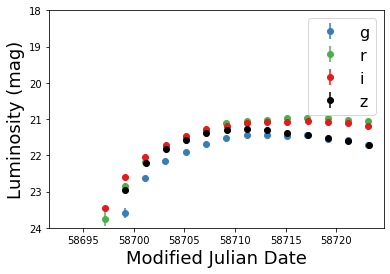

In [32]:
plot_lc(lc1)

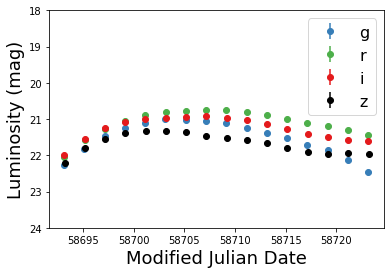

In [33]:
plot_lc(lc2)

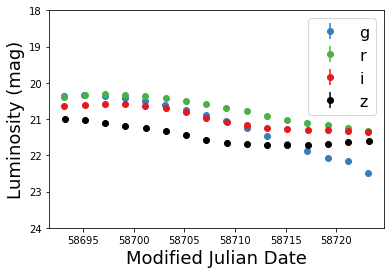

In [34]:
plot_lc(lc3)

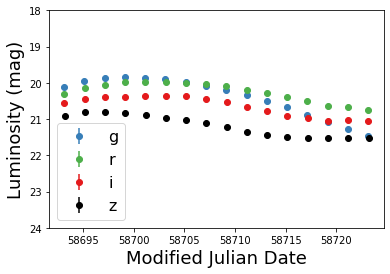

In [35]:
plot_lc(lc4)

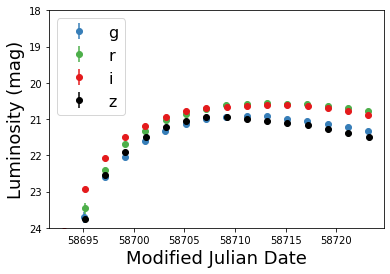

In [36]:
plot_lc(lc5)

## Model

See the [arXiv](https://arxiv.org/pdf/1905.07422.pdf) paper here. This model is meant to broadly fit SNe light curves. We will approach it using the ensemble sampler of `emcee`.

### Predicitons

In [80]:
def get_model_predictions(theta, t):
    trise, tfall, t0, A, beta, c, gamma = theta
    t1 = gamma + t0
    
    #define the model using the piecewise representation
    tsmall = t[np.where(t < t1)]
    tbig = t[np.where(t >= t1)]
    
    F_tsmall = (A + beta * (tsmall - t0)) / (1 + np.exp(-1.0 * (tsmall - t0) / trise))
    F_tbig = (A + beta * (tbig - t0)) * np.exp(-1.0 * (tbig - t1) / tfall) / (1.0 + np.exp((tbig - t0) / trise))
    
    F = np.array([x for x in F_tsmall] + [x for x in F_tbig])

    #if t < t1:
    #    F = (A + beta * (t - t0)) / (1 + np.exp(-1.0 * (t - t0) / trise))
    #else:
    #    F = (A + beta * (t - t0)) * np.exp(-1.0 * (t - t1) / tfall) / (1.0 + np.exp((t - t0) / trise))
        
    return F

### Priors

In [246]:
def log_prior_full(theta, fmax, sigma_f):
    trise, tfall, t0, A, beta, c, gamma = theta
    contrib = 0.0
    
    #trise
    if 0.01 < trise < 50: 
        contrib += np.log(1. / (50. - 0.01))
    else:
        return -np.inf
    
    #tfall
    if 1 < trise < 300: 
        contrib += np.log(1. / (300. - 1.))
    else:
        return -np.inf 
    
    #t0
    tmin = 58693.0
    tmax = 58733.0
    if tmin - 50.0 < t0 < tmax + 300.0:
        contrib += np.log(1. / (tmax + 300.0 - tmin + 50.0))
    else:
        return -np.inf
    
    #A
    if 3 * sigma_f < A < 100 * fmax:
        contrib += np.log(1. / (100 * fmax - 3 * sigma_f))
    else:
        return -np.inf
    
    
    #beta
    if -1.0 * fmax / 150.0 < beta < 0.0:
        contrib += np.log(1. / (fmax / 150.0))
    else:
        return -np.inf
    
    #c
    if -3.0 * sigma_f < c < 3.0 * sigma_f:
        contrib += np.log(1. / (6.0 * sigma_f))
    else:
        return -np.inf
    
    #gamma
    rv1 = st.norm(5, 5)
    rv2 = st.norm(60, 30)
    contrib += np.log((2./3.) * rv1(gamma) + (1./3.) * rv2(gamma))
    
    return contrib

In [247]:
def log_prior(theta, fmax, sigma_f):
    
    trise, tfall, t0, A, beta, c, gamma = theta
    contrib = 0.0
    
    if trise < 10 and trise > 0:
        contrib += np.log(1./10.)
    else:
        return -np.inf
    
    if tfall > 75 and tfall < 85:
        contrib += np.log(1./10.)
    else:
        return -np.inf
    
    if t0 > 5.87003038e+04 and t0 < 5.87103038e+04:
        contrib += np.log(1./10.)
    else:
        return -np.inf
    
    if A > 485 and A < 495:
        contrib += np.log(1./10.)
    else:
        return -np.inf
    
    if beta > -10 and beta < 0:
        contrib += np.log(1./10.)
    else:
        return -np.inf
    
    if c > 25 and c < 35:
        contrib += np.log(1./10.)
    else:
        return -np.inf
    
    if gamma > 95 and gamma < 105:
        contrib += np.log(1./10.)
    else:
        return -np.inf
    
    return contrib
    
    
    #init_me = [4, 80, 5.87053038e+04, 490, -5, 30, 100]

### Likelihood

In [248]:
def log_like(theta, t, f, f_unc):
    
    model_preds = get_model_predictions(theta, t)
    return -0.5 * np.sum((f - model_preds)**2 / np.exp(2*f_unc) + 2*f_unc)

### Probability

In [249]:
def log_prob(theta, t, f, f_unc):
    
    fmax = np.max(f)
    sigma_f = np.std(f)
    
    return log_prior(theta, fmax, sigma_f) + log_like(theta, t, f, f_unc)

## Preprocessing

Try to find the optimum so we just sample nearby

In [122]:
def nll(*par):
    return -1.0 * log_like(*par)

def lc_chooser_nll(theta, lc, flt):
    flt_lc = lc[lc['FLT'] == flt]
    
    t = flt_lc['MJD'].values
    f = flt_lc['FLUXCAL'].values
    f_unc = flt_lc['FLUXCALERR'].values
    
    return nll(theta, t, f, f_unc)

In [123]:
g_t = lc1[lc1['FLT'] == 'r']['MJD'].values
g_f = lc1[lc1['FLT'] == 'r']['FLUXCAL'].values
g_func = lc1[lc1['FLT'] == 'r']['FLUXCALERR'].values

print(init[0])

res = minimize(lc_chooser_nll, init[0],
               args=(lc1, 'r'),
               method='Powell')
print('Optimizer finished with message "{0}" and \n\
      best-fit parameters {1}'.format(res['message'], res['x']))

[ 9.96882163e+00  1.00072900e+02  5.87000218e+04  1.82774101e+04
 -5.12267807e+00  9.13251521e-02  1.12706373e-01]
Optimizer finished with message "Optimization terminated successfully." and 
      best-fit parameters [ 1.68909445e-01  1.76853740e+11  5.87003038e+04  2.29171325e+04
 -5.79350961e+03  5.26718308e+00  3.47518098e-01]


In [250]:
init_best = [4, 80, 5.87053038e+04, 490, -5, 30, 100]

init_best = init_best + 0.1 * np.random.randn(100, 7)


## Sampling

Set initial location in parameter space

In [108]:
np.random.seed(6)
#initialize in the center-ish of the prior

trise = 10.0
tfall = 100.0
t0 = 58700.0
A = 75.0 * np.median(lc1['FLUXCAL'].values)
beta = -1.0 * np.median(lc1['FLUXCAL'].values) / 50.0
c = 0.0
gamma = 0.0  


init = np.array([trise, tfall, t0, A, beta, c, gamma])
init = init + 0.1 * np.random.randn(100, 7)

Choose a light curve for the fit

In [125]:
def lc_chooser(theta, lc, flt):
    flt_lc = lc[lc['FLT'] == flt]
    
    t = flt_lc['MJD'].values
    f = flt_lc['FLUXCAL'].values
    f_unc = flt_lc['FLUXCALERR'].values
    
    return log_prob(theta, t, f, f_unc)

In [251]:
emcee_sampler = emcee.EnsembleSampler(len(init_best), 7, lc_chooser, args=(lc1, 'r'))
emcee_sampler.run_mcmc(init_best, 4000, progress=True);

100%|██████████| 4000/4000 [05:37<00:00, 11.86it/s]


In [252]:
tau = emcee_sampler.get_autocorr_time()
print("Integrated autocorrelation times:")
for i, k in enumerate(["trise", "tfall", "t0", "A", "beta", "c", "gamma"]):
    print("{0}: {1}".format(k, tau[i]))

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 80;
tau: [210.73343396 193.16971092 201.47510254 222.43621451 209.01406665
 227.99159888 213.89066412]

In [254]:
print(tau)

[nan nan nan nan nan nan nan]


In [253]:
tau_max = int(tau.max())
emcee_samples = emcee_sampler.get_chain(discard=5*tau_max, flat=True)
emcee_samples = np.array(emcee_get_params(emcee_samples.T)).T

print("Effective number of samples for each parameter:")
print(len(emcee_samples) / emcee_sampler.get_autocorr_time(discard=5*tau_max))

ValueError: cannot convert float NaN to integer

In [271]:
emcee_samples = emcee_sampler.get_chain()
np.shape(emcee_samples)

(4000, 100, 7)

In [274]:
params = np.mean(emcee_samples, axis=1)[-1,:]
print(params)

[ 4.78659441e+00  7.99600161e+01  5.87052934e+04  4.90819219e+02
 -4.93209588e+00  3.00496630e+01  1.00275535e+02]


In [257]:
np.shape(emcee_samples)

(4000, 100, 7)

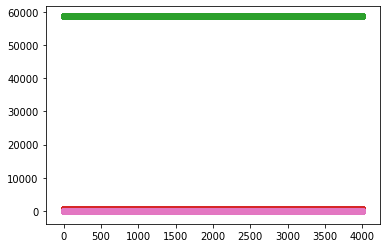

In [258]:
for i in range(7):
    plt.scatter(np.arange(1, 4001), emcee_samples[:,0,i])

In [268]:
corner.corner(emcee_samples)

AssertionError: The input sample array must be 1- or 2-D.

# Sandbox

In [240]:
#["trise", "tfall", "t0", "A", "beta", "c", "gamma"]]
init_best = [1.68909445e-01, 1.76853740e+11, 5.87003038e+04, 2.29171325e+04, -5.79350961e+03, 5.26718308e+00, 3.47518098e-01]
t = lc1[lc1['FLT'] == 'r']['MJD'].values
init_me = [4, 80, 5.87053038e+04, 490, -5, 30, 100]
f_pred = get_model_predictions(init_me, t)

In [275]:
f_pred_mc = get_model_predictions(params, t)

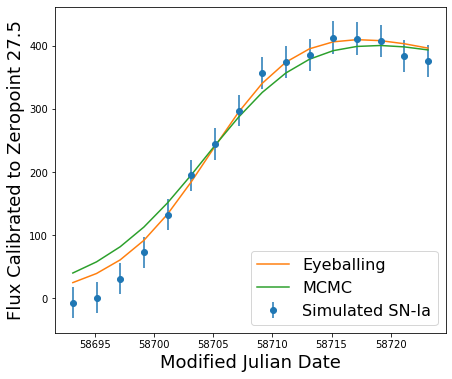

In [279]:
plt.figure(figsize=(7, 6))
plt.errorbar(lc1[lc1['FLT'] == 'r']['MJD'].values, lc1[lc1['FLT'] == 'r']['FLUXCAL'].values, yerr=lc1[lc1['FLT'] == 'r']['FLUXCALERR'].values * 4, fmt='o', label='Simulated SN-Ia')
plt.plot(lc1[lc1['FLT'] == 'r']['MJD'].values, f_pred, label='Eyeballing')
plt.plot(lc1[lc1['FLT'] == 'r']['MJD'].values, f_pred_mc, label='MCMC')
plt.xlabel("Modified Julian Date", fontsize=18)
plt.ylabel("Flux Calibrated to Zeropoint 27.5", fontsize=18)
plt.legend(fontsize=16, loc='lower right')

plt.show()

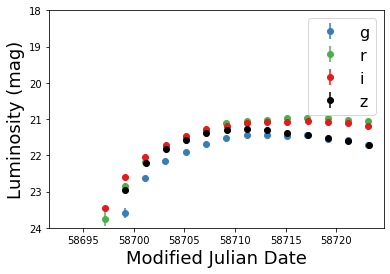

In [263]:
plot_lc(lc1)